Speech recognition - Autoencoder

In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import winsound
import time
import librosa

from IAHOS import IAHOS
from extraction_performances import extraction_performances
from hyperparams_initialization import hyperparams_initialization
from plots import plot_IAHOS,plot_confusion_matrix
from plots import plot_training_accuracy,plot_validation_accuracy,plot_test_scores
from plots import plot_output_NN,plot_AE_pre
from pretraining_AE import pretraining1_AE

import keras
from keras import backend as K
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,Conv1D,MaxPooling2D,AveragePooling2D,MaxPooling1D
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,UpSampling2D
from keras import initializers,optimizers,backend as k
from keras_radam import RAdam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score


Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [27]:
print (test_labels.shape)

(1500, 5)


In [6]:
training_set=np.load('mfcc_training_set.npy')
training_labels=np.load('mfcc_training_labels.npy')
validation_set=np.load('mfcc_validation_set.npy')
validation_labels=np.load('mfcc_validation_labels.npy')
test_set=np.load('mfcc_test_set.npy')
test_labels=np.load('mfcc_test_labels.npy')
words_name=np.load('words_name.npy')
randomize = np.arange(len(training_set))
np.random.shuffle(randomize)
training_set = training_set[randomize]
randomize = np.arange(len(validation_set))
np.random.shuffle(randomize)
validation_set = validation_set[randomize]
randomize = np.arange(len(test_set))
np.random.shuffle(randomize)
test_set = test_set[randomize]
percentage = 30
index1 = int(len(training_set)*percentage/100)
index2 = int(len(validation_set)*percentage/100)
training_set2 = training_set[0:index1].reshape((-1,12,99,1))
training_labels2 = training_labels[0:index1]
validation_set2 = validation_set[0:index2].reshape((-1,12,99,1))
validation_labels2 = validation_labels[0:index2]
training_set = training_set.reshape((-1,12,99,1))
validation_set = validation_set.reshape((-1,12,99,1))
test_set = test_set.reshape((-1,12,99,1))

In [7]:
def encoder(input_img,layers,filters,kernel,dropout):
    conv = input_img
    for j in range(layers):
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate=dropout)(conv)
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate=dropout)(conv)
        conv = MaxPooling2D(pool_size=(2, 3))(conv)
    return conv

def decoder(conv,layers,filters,kernel,dropout): 
    decoded = conv
    for j in range(layers):
        decoded = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(decoded)
        decoded = Dropout(rate=dropout)(decoded)
        decoded = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(decoded)
        decoded = Dropout(rate=dropout)(decoded)
        decoded = UpSampling2D((2,3))(decoded)
    decoded = Conv2D(1, (2, 2),padding='same')(decoded)
    return decoded

In [8]:
input_img = Input(shape = (12, 99,1))
number_epochs=100
train_loss=[]
val_loss=[]
mc = ModelCheckpoint('best_AE.h5',monitor='val_loss',mode='min',verbose=0,save_best_only=True)
autoencoder = Model(input_img, decoder(encoder(input_img,2,4,2,0),
                                               2,4,2,0))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')
autoencoder_train = autoencoder.fit(training_set, training_set, batch_size=256,epochs=number_epochs,
                                    verbose=2,validation_data=(validation_set, validation_set))
train_loss.append(autoencoder_train.history['loss'])
val_loss.append(autoencoder_train.history['val_loss'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 5000 samples
Epoch 1/100
 - 7s - loss: 81.9837 - val_loss: 63.2522
Epoch 2/100
 - 4s - loss: 75.2463 - val_loss: 59.0303
Epoch 3/100
 - 4s - loss: 62.5530 - val_loss: 47.2672
Epoch 4/100
 - 4s - loss: 49.9767 - val_loss: 43.7705
Epoch 5/100
 - 4s - loss: 46.6809 - val_loss: 40.0361
Epoch 6/100
 - 4s - loss: 45.4933 - val_loss: 38.8120
Epoch 7/100
 - 4s - loss: 44.1634 - val_loss: 39.0074
Epoch 8/100
 - 4s - loss: 43.5581 - val_loss: 37.6372
Epoch 9/100
 - 4s - loss: 43.0647 - val_loss: 37.1800
Epoch 10/100
 - 4s - loss: 42.5926 - val_loss: 37.6314
Epoch 11/100
 - 4s - loss: 42.0697 - val_loss: 36.5635
Epoch 12/100
 - 4s - loss: 41.5046 - val_loss: 36.0889
Epoch 13/100
 - 4s - loss: 41.2102 - val_loss: 35.9848
Epoch 14/100
 - 4s - loss: 40.5752 - val_loss: 35.4453
Epoch 15/100
 - 4s - loss: 40.2573 - val_loss: 35.8658
Epoch 16/100
 -

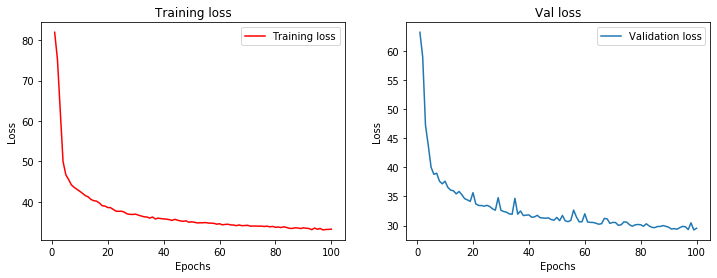

In [9]:
Epochs = np.linspace(1,number_epochs,number_epochs)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
plt.setp(ax.flat, xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training loss')
ax[0].plot(Epochs, train_loss[0],'r',label='Training loss')
ax[0].legend()

ax[1].set_title('Val loss')
plt.plot(Epochs, val_loss[0],label='Validation loss')
ax[1].legend()
plt.savefig('Final Train and val losses of the AE')
plt.show()

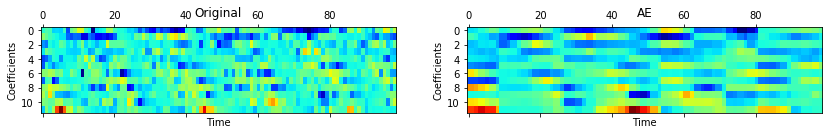

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
plt.setp(ax.flat, xlabel='Time', ylabel='Coefficients')
ax[0].set_title('Original')
ax[0].matshow(training_set[900][:,:,0],cmap=plt.cm.jet,aspect=2)

ax[1].set_title('AE')
ax[1].matshow(autoencoder.predict(training_set[900].reshape(-1,12,99,1))[0,:,:,0],cmap=plt.cm.jet,
             aspect=2)
plt.savefig('AE reconstruction')
plt.show()

In [ ]:
audio=librosa.feature.inverse.mfcc_to_audio(autoencoder.predict(training_set[10].reshape(-1,40,99,1))[0,:,:,0],200)
print (audio.shape)

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [14]:
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 99, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 99, 6)         30        
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 99, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 99, 6)         150       
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 99, 6)         0         
__________

In [15]:
def encoder(input_img,layers,filters,kernel,dropout):
    conv = input_img
    for j in range(layers):
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate=dropout)(conv)
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate=dropout)(conv)
        conv = MaxPooling2D(pool_size=(2, 1))(conv)
    return conv

In [16]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(500,activation='relu')(flat)
    out = Dense(5, activation='softmax')(den)
    return out

In [17]:
layer=2
Filter=4
kernel=2
encode = encoder(input_img,layer,Filter,kernel,0)#0 dropout because now we don't 
#train the encoder of the AE part anymore
full_model = Model(input_img,fc(encode))

In [18]:
print (full_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 99, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 99, 6)         30        
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 99, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 99, 6)         150       
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 99, 6)         0         
__________

In [19]:
for l1,l2 in zip(full_model.layers[:15],autoencoder.layers[:15]):
    l1.set_weights(l2.get_weights())

In [20]:
for layer in full_model.layers[:15]:
    layer.trainable = False

In [21]:
full_model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [22]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 99, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 99, 6)         30        
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 99, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 99, 6)         150       
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 99, 6)         24        
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 99, 6)         0         
__________

In [23]:
classify_train = full_model.fit(training_set, training_labels, batch_size=256,epochs=30,
                                verbose=2,validation_data=(validation_set, validation_labels))

ValueError: Input arrays should have the same number of samples as target arrays. Found 40000 input samples and 12000 target samples.

In [ ]:
acc = classify_train.history['acc']
val_acc = classify_train.history['val_acc']
epochs = range(30)
plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test set - Confusion matrix

In [ ]:
classifier=full_model
predictions = classifier.predict(test_set.reshape(-1,40,99,1))
new_test_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])
plot_confusion_matrix(new_test_labels,y_pred,words_name,'AE')